In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np

In [17]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

def read_and_decode(filename, resize_dims):
    img_bytes = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, resize_dims)
    return img

def parse_csvline(csv_line):
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]
    return img, label

In [18]:
train_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(8)
            .prefetch(tf.data.AUTOTUNE)
)

eval_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
        .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(8)
        .prefetch(tf.data.AUTOTUNE)
)

In [19]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),
    include_top = False,
    weights = "imagenet"
)

base_model.trainable = True

In [20]:
model = keras.Sequential([
            base_model,
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.BatchNormalization(),       # Add BatchNorm
            keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
        ])

In [21]:
base_learning_rate = 1e-5
head_learning_rate = 1e-4  # Example: 1e-4

optimizer = tf.keras.optimizers.Adam()

for layer in model.layers[0].layers:  # Layers inside base_model
    layer.trainable = True
    layer._learning_rate = base_learning_rate

for layer in model.layers[1:]:
    layer._learning_rate = head_learning_rate

# Compile the model with the learning rate schedule
model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["accuracy"])

# Visualize model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,509 (8.66 MB)

 Trainable params: 2,232,837 (8.52 MB)

 Non-trainable params: 36,672 (143.25 KB)

In [22]:
history = model.fit(
            train_dataset,
            validation_data=eval_dataset,
            epochs=5)

Epoch 1/5
    413/Unknown 801s 2s/step - accuracy: 0.5758 - loss: 1.6237

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 894s 2s/step - accuracy: 0.5759 - loss: 1.6229 - val_accuracy: 0.3649 - val_loss: 5.5454
Epoch 2/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 699s 2s/step - accuracy: 0.6779 - loss: 0.9689 - val_accuracy: 0.2324 - val_loss: 9.9464
Epoch 3/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 694s 2s/step - accuracy: 0.7238 - loss: 0.7796 - val_accuracy: 0.2514 - val_loss: 7.7879
Epoch 4/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 726s 2s/step - accuracy: 0.7425 - loss: 0.7577 - val_accuracy: 0.4838 - val_loss: 4.7455
Epoch 5/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 754s 2s/step - accuracy: 0.7998 - loss: 0.5579 - val_accuracy: 0.6108 - val_loss: 3.7818


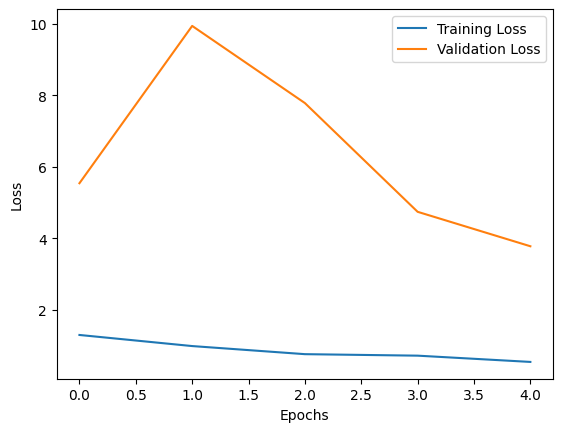

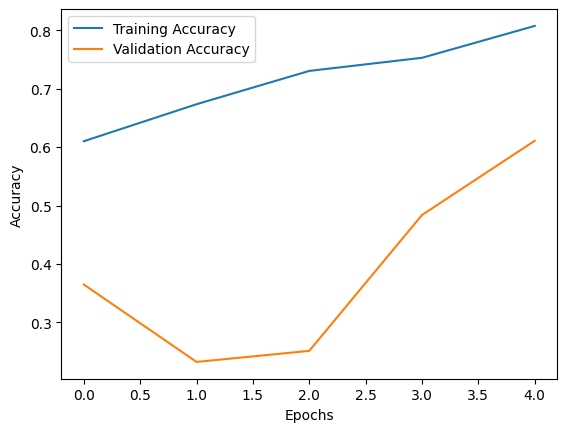

In [23]:
plt.plot(history.history["loss"],label = "Training Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"],label = "Training Accuracy")
plt.plot(history.history["val_accuracy"],label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()